# Evaluation of SCA-Protected Implementations of Ascon128

- Plain/Shared SimpleSerial interface
- Plain/Shared AEAD interface
- STM32F4/STM32F3/STM32F0

### Note

- Make sure this jupyter script is located in the `jupyter` folder of your chipwhisperer installation.
- Make sure https://github.com/ascon/simpleserial-ascon is checked out in `hardware/victims/firmware` of your chipwhisperer installation:
```
cd hardware/victims/firmware
git clone https://github.com/ascon/simpleserial-ascon.git
```
- Currently, SS_VER_2_1 only works on the chipwhisperer develop branch (factor 5.5x compared to SS_VER_1_1)
- For more performance with SS_VER_1_1 (factor 3.5x), set the baud rate to 230400 for SS_VER != SS_VER_2_0:

```
// in e.g. hardware/victims/firmware/hal/stm32f4/stm32f4_hal.c:
UartHandle.Init.BaudRate = 230400;
```
- `SS_SHARED = 1` transfers the data in shares and calls `crypto_aead_encrypt_shared` or `crypto_aead_decrypt_shared`
- `SS_SHARED = 0` transfers the data in plain and calls `crypto_aead_encrypt` or `crypto_aead_decrypt`

In [1]:
PLATFORM = 'CW308_STM32F3'
CRYPTO_TARGET = 'NONE'
SCOPETYPE = 'OPENADC'
SS_VER = 'SS_VER_2_1'
#SS_VER = 'SS_VER_1_1'
BAUD_RATE = 230400
SS_SHARED = 1
DATA_LEN = 190
RESP_LEN = 96

## Detect Chipwhisperer Board

In [2]:
%run "Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍
scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.samples                        changed from 24400                     to 5000                     
scope.adc.trig_count                     changed from 19354594                  to 65958328                 
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.adc_freq                     changed from 96000000                  to 137900367                
scope.clock.adc_rate                     changed from 96000000.0                to 137900367.0       

### Setup Target Algorithm

In [3]:
CRYPTO_PATH = 'Implementations/crypto_aead/ascon128v12/protected_bi32_armv6'
NUM_SHARES_KEY = 2
NUM_SHARES_NPUB =2
NUM_SHARES_AD = 2
NUM_SHARES_M = 2
NUM_SHARES_C = 2
ASCON_ROR_SHARES = 5
ASCON_EXTERN_BI = 0
ASCON_EXTERN_BE = 1
ASCON_PA_ROUNDS = 12 
ASCON_PB_ROUNDS = 6 
TRACES = 10000

In [4]:
EXTRA_OPTS = ' -DNUM_SHARES_KEY=' + str(NUM_SHARES_KEY)
EXTRA_OPTS += ' -DNUM_SHARES_NPUB=' + str(NUM_SHARES_NPUB)
EXTRA_OPTS += ' -DNUM_SHARES_AD=' + str(NUM_SHARES_AD)
EXTRA_OPTS += ' -DNUM_SHARES_M=' + str(NUM_SHARES_M)
EXTRA_OPTS += ' -DNUM_SHARES_C=' + str(NUM_SHARES_C)
EXTRA_OPTS += ' -DASCON_ROR_SHARES=' + str(ASCON_ROR_SHARES)
EXTRA_OPTS += ' -DASCON_EXTERN_BI=' + str(ASCON_EXTERN_BI)
EXTRA_OPTS += ' -DASCON_PA_ROUNDS=' + str(ASCON_PA_ROUNDS)
EXTRA_OPTS += ' -DASCON_PB_ROUNDS=' + str(ASCON_PB_ROUNDS)
EXTRA_OPTS += ' -DSS_SHARED=' + str(SS_SHARED)
EXTRA_OPTS += ' -DDATA_LEN=' + str(DATA_LEN)
EXTRA_OPTS += ' -DRESP_LEN=' + str(RESP_LEN)

## Compile

In [5]:
%%bash -s "$SS_VER" "$PLATFORM" "$CRYPTO_TARGET" "$CRYPTO_PATH" "$EXTRA_OPTS" "-Os"
cd ../hardware/victims/firmware/simpleserial-asconV
rm -rf objdir-$2/$4 objdir/$4 objdir .dep
mkdir -p objdir-$2/$4 objdir/$4
make SS_VER=$1 PLATFORM=$2 CRYPTO_TARGET=$3 CRYPTO_PATH=$4 EXTRA_OPTS="$5" OPT=s

Building for platform CW308_STM32F3 with CRYPTO_TARGET=NONE
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
Building for platform CW308_STM32F3 with CRYPTO_TARGET=NONE
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
mkdir -p .dep
Building for platform CW308_STM32F3 with CRYPTO_TARGET=NONE
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:10.3-2021.07-4) 10.3.1 20210621 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling:
-en     simpleserial-ascon.c ...
-e Done!
.
Compiling:
-en     randombytes.c ...
-e Done!
.
Compiling:
-en     Implementations/crypto_aead/ascon128v12/protected_bi32_armv6/aead.c ...
-e Done!
.
Compiling:
-en     Implementations/crypto_aead/ascon128v12/protected_bi32_armv6/constants.c ...
-e Done!
.
Compiling:
-en   

## Flash Binary on the Victim Board

**Note:** If you use a STM32F target board of Revision-02 then you first need to set a specific jumper cable on the UFO board for the following code to work.

For more information have a look here: https://rtfm.newae.com/Targets/UFO%20Targets/CW308T-STM32F/

In [6]:
HEXFILE = "../hardware/victims/firmware/simpleserial-asconV/simpleserial-ascon-" + PLATFORM + ".hex"
cw.program_target(scope, prog, HEXFILE)

Detected unknown STM32F ID: 0x446
Extended erase (0x44), this can take ten seconds or more
Attempting to program 17403 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 17403 bytes


## Communication Test

In [7]:
target.flush()

try:
    target.baud = BAUD_RATE
except:
    pass

print('Baudrate:')
print(target.baud)

print('Available Commands:')
print(*target.get_simpleserial_commands(),sep = "\n")

Baudrate:
230400
Available Commands:
{'cmd': b'v', 'len': 0, 'flags': 0}
{'cmd': b'w', 'len': 0, 'flags': 0}
{'cmd': b'a', 'len': 0, 'flags': 0}
{'cmd': b'e', 'len': 0, 'flags': 0}


## Echo Test

In [8]:
import time

CMD_ECHO_TEST = 'e'

data = bytearray.fromhex(''.join('{:02x}'.format(x) for x in list(range(DATA_LEN))))

target.flush()
target.simpleserial_write(CMD_ECHO_TEST, data)
time.sleep(0.1)
response = target.simpleserial_read('r', RESP_LEN, end='\n', timeout=250, ack=True)

# SS_VER_2_1 commands:
#arget.send_cmd(CMD_ECHO_TEST, 0x00, data)
#response = target.read_cmd(cmd=None, pay_len=None, timeout=250, flush_on_err=None)

print(list(response))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]


## Interface Functions

In [9]:
def pad(data):
    if len(data) > DATA_LEN:
        print("data length: " + str(len(data)))
    assert(len(data) <= DATA_LEN)
    if SS_VER == 'SS_VER_1_1':
        data += bytearray.fromhex('00'*(DATA_LEN-len(data)))
    return data

def bswap64(x):
    y = np.zeros((len(x)+7)//8*8, dtype=np.uint8)
    for i in range(len(x)):
        y[i // 8 * 8 + 7 - i % 8] = x[i]
    return y

def ror(v, r, s):
    return ((v & (2**s - 1)) >> (r % s) | (v << (s - (r % s)) & (2**s - 1)))

def tobi(x):
    y = np.zeros((len(x)+7)//8*8, dtype=np.uint8)
    for i in range(len(x)):
        for j in range(4):
            e = (x[i] >> (j * 2)) & 1
            o = (x[i] >> (j * 2 + 1)) & 1
            y[(i//8)*8+(i%8)//2] |= e << ((i%2) * 4 + j)
            y[(i//8)*8+(i%8)//2+4] |= o << ((i%2) * 4 + j)
    return y

def frombi(x):
    y = np.zeros((len(x)+7)//8*8, dtype=np.uint8)
    for i in range(len(x)):
        for j in range(4):
            e = (x[(i//8)*8+(i%8)//2] >> ((i%2) * 4 + j)) & 1
            o = (x[(i//8)*8+(i%8)//2+4] >> ((i%2) * 4 + j)) & 1
            y[i] |= e << (j * 2)
            y[i] |= o << (j * 2 + 1)
    return y

def size_shares(l, ns):
    return ((l + 7) // 8) * 8 * ns

def generate_shares(x, ns):
    l = size_shares(len(x), ns) // ns
    xs = np.zeros((l // 4, ns, 4), dtype=np.uint8)
    if ASCON_EXTERN_BE:
        x = bswap64(x)
    if ASCON_EXTERN_BI:
        x = tobi(x)
    for i in range(len(x)):
        xs[i // 4][0][i % 4] = x[i]
    for i in range(0, l // 4, 2):
        for j in range(1, ns):
            r0 = random.getrandbits(32)
            r1 = random.getrandbits(32)
            if ASCON_EXTERN_BI:
                m = ror(r1, ASCON_ROR_SHARES * j, 32) << 32 | ror(r0, ASCON_ROR_SHARES * j, 32)
            else:
                m = ror(r1 << 32 | r0, 2 * ASCON_ROR_SHARES * j, 64)
            for k in range(4):
                xs[i + 0][0][k] ^= (m >> (k * 8)) & 0xff
                xs[i + 1][0][k] ^= (m >> (k * 8 + 32)) & 0xff
                xs[i + 0][j][k] ^= (r0 >> (k * 8)) & 0xff
                xs[i + 1][j][k] ^= (r1 >> (k * 8)) & 0xff
    xs = xs.flatten()
    return bytearray(xs)
    
def combine_shares(xs, ns):
    l = len(xs) // ns
    xs = np.reshape(xs, (l // 4, ns, 4))
    x = np.zeros((l // 4, 4), dtype=np.uint8)
    for i in range(0, l // 4, 2):
        for j in range(ns):
            r0 = r1 = 0
            for k in range(4):
                r0 |= int(xs[i + 0][j][k]) << (k * 8)
                r1 |= int(xs[i + 1][j][k]) << (k * 8)
            if ASCON_EXTERN_BI:
                m = ror(r1, ASCON_ROR_SHARES * j, 32) << 32 | ror(r0, ASCON_ROR_SHARES * j, 32)
            else:
                m = ror(r1 << 32 | r0, 2 * ASCON_ROR_SHARES * j, 64)
            for k in range(4):
                x[i + 0][k] ^= (m >> (k * 8)) & 0xff
                x[i + 1][k] ^= (m >> (k * 8 + 32)) & 0xff
    x = x.flatten()
    if ASCON_EXTERN_BI:
        x = frombi(x)
    if ASCON_EXTERN_BE:
        x = bswap64(x)
    return bytearray(x)

In [10]:
if SS_SHARED == 0:
    def size_shares(l, ns):
        return l
    def generate_shares(x, ns):
        return bytearray(x)
    def combine_shares(xs, ns):
        return bytearray(xs)

## Interface Constants

In [11]:
import numpy as np
import random

# Command
CMD_ASCON = 'a'
CMD_ECHO_TEST = 'e'

# Flags
M = 0x01              # data contains message 
C = 0x02              # data contains ciphertext
A = 0x04              # data contains associated data
N = 0x08              # data contains nonce
K = 0x10              # data contains key
RUN_ENC = 0x20        # run enc after data transmission
RUN_DEC = 0x40        # run dec after data transmission
OMIT_RESULT = 0x80    # omit returning result after encryption/decryption

## Encryption:  `mlen = 0`, `alen = 0`

In [12]:
# Define input data
m = bytearray.fromhex('')
a = bytearray.fromhex('')
n = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
k = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')

# Send nonce and key
data = bytearray([N|K])
data += generate_shares(n, NUM_SHARES_NPUB)
data += generate_shares(k, NUM_SHARES_KEY)
target.flush()
target.simpleserial_write(CMD_ASCON, pad(data))
time.sleep(0.1)

# Send and receive data
data = bytearray([M|A|RUN_ENC])
data += bytearray([len(m)]) + generate_shares(m, NUM_SHARES_M)
data += bytearray([len(a)]) + generate_shares(a, NUM_SHARES_AD)
target.flush()
target.simpleserial_write(CMD_ASCON, pad(data))
time.sleep(0.1)
response = target.simpleserial_read('r', RESP_LEN, end='\n', timeout=250, ack=True)

# Extract and print response
mlen = size_shares(len(m), NUM_SHARES_C)
tlen = size_shares(16, NUM_SHARES_C)
c = combine_shares(response[0:mlen], NUM_SHARES_C)
t = combine_shares(response[mlen:mlen + tlen], NUM_SHARES_C)
print('c: ' + ''.join('{:02x}'.format(x) for x in c[:len(m)]))
print('t: ' + ''.join('{:02x}'.format(x) for x in t))

c: 
t: e355159f292911f794cb1432a0103a8a


## Encryption:  `mlen = 4`, `alen = 4`

In [74]:
# Define input data
m = bytearray.fromhex('00010203')
a = bytearray.fromhex('00010203')
n = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
k = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')

# Send nonce and key
data = bytearray([N|K])
data += generate_shares(n, NUM_SHARES_NPUB)
data += generate_shares(k, NUM_SHARES_KEY)
target.flush()
target.simpleserial_write(CMD_ASCON, pad(data))
time.sleep(0.1)

# Send and receive data
data = bytearray([M|A|RUN_ENC])
data += bytearray([len(m)]) + generate_shares(m, NUM_SHARES_M)
data += bytearray([len(a)]) + generate_shares(a, NUM_SHARES_AD)
target.flush()
target.simpleserial_write(CMD_ASCON, pad(data))
time.sleep(0.1)
response = target.simpleserial_read('r', RESP_LEN, end='\n', timeout=250, ack=True)

# Extract and print response
mlen = size_shares(len(m), NUM_SHARES_C)
tlen = size_shares(16, NUM_SHARES_C)
c = combine_shares(response[0:mlen], NUM_SHARES_C)
t = combine_shares(response[mlen:mlen + tlen], NUM_SHARES_C)
print('c: ' + ''.join('{:02x}'.format(x) for x in c[:len(m)]))
print('t: ' + ''.join('{:02x}'.format(x) for x in t))

c: 7763f8ba
t: 02b1e06bc3f2370da5b314302543e9d0


## Decryption, `clen = 0`, `alen = 0`

In [14]:
# Define input data
c = bytearray.fromhex('e355159f292911f794cb1432a0103a8a')
a = bytearray.fromhex('')
n = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
k = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')

# Send nonce and key
data = bytearray([N|K])
data += generate_shares(n, NUM_SHARES_NPUB)
data += generate_shares(k, NUM_SHARES_KEY)
target.flush()
target.simpleserial_write(CMD_ASCON, pad(data))
time.sleep(0.1)

# Send and receive data
data = bytearray([C|A|RUN_DEC])
data += bytearray([len(c)]) + generate_shares(c[0:-16], NUM_SHARES_C) + generate_shares(c[-16:], NUM_SHARES_C)
data += bytearray([len(a)]) + generate_shares(a, NUM_SHARES_AD)
target.flush()
target.simpleserial_write(CMD_ASCON, pad(data))
time.sleep(0.1)
response = target.simpleserial_read('r', RESP_LEN, end='\n', timeout=250, ack=True)

# Extract and print response
result = response[0]
mlen = size_shares(len(c)-16, NUM_SHARES_M)
m = combine_shares(response[1:1+mlen], NUM_SHARES_M)
print('r: ' + '{:02x}'.format(result))
print('m: ' + ''.join('{:02x}'.format(x) for x in m))

r: ff
m: 


## Decryption, `clen = 4`, `alen = 4`

In [13]:
# Define input data
c = bytearray.fromhex('7763f8ba02b1e06bc3f2370da5b314302543e9d0')
a = bytearray.fromhex('00010203')
n = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
k = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')

# Send nonce and key
data = bytearray([N|K])
data += generate_shares(n, NUM_SHARES_NPUB)
data += generate_shares(k, NUM_SHARES_KEY)
target.flush()
target.simpleserial_write(CMD_ASCON, pad(data))
time.sleep(0.1)

# Send and receive data
data = bytearray([C|A|RUN_DEC])
data += bytearray([len(c)]) + generate_shares(c[0:-16], NUM_SHARES_C) + generate_shares(c[-16:], NUM_SHARES_C)
data += bytearray([len(a)]) + generate_shares(a, NUM_SHARES_AD)
target.flush()
target.simpleserial_write(CMD_ASCON, pad(data))
time.sleep(0.1)
response = target.simpleserial_read('r', RESP_LEN, end='\n', timeout=250, ack=True)

# Extract and print response
result = response[0]
mlen = size_shares(len(c)-16, NUM_SHARES_M)
m = combine_shares(response[1:1+mlen], NUM_SHARES_M)
print('r: ' + '{:02x}'.format(result))
print('m: ' + ''.join('{:02x}'.format(x) for x in m[:len(c)-16]))

r: 00
m: 00010203


## Sweep: Encryption/Decryption,  `mlen = 0...7`, `alen = 0...7`

In [40]:
m = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
a = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
n = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
k = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')

target.flush()

for mlen in range(1):
    for alen in range(8):
        print('mlen: {}, alen: {}'.format(mlen,alen), end='')
        #print(' m: ' + ''.join('{:02x}'.format(x) for x in m[:mlen]), end='')
        #print(' a: ' + ''.join('{:02x}'.format(x) for x in a[:alen]), end='')
        # Send key and nonce #
        data = bytearray([N|K])
        data += generate_shares(n, NUM_SHARES_NPUB)
        data += generate_shares(k, NUM_SHARES_KEY)
        target.flush()
        target.simpleserial_write(CMD_ASCON, pad(data))
        time.sleep(0.1)
        # Encrypt #
        data = bytearray([M|A|RUN_ENC])
        data += bytearray([mlen]) + generate_shares(m[:mlen], NUM_SHARES_M)
        data += bytearray([alen]) + generate_shares(a[:alen], NUM_SHARES_AD)
        target.flush()
        target.simpleserial_write(CMD_ASCON, pad(data))
        time.sleep(0.1)
        response = target.simpleserial_read('r', RESP_LEN, end='\n', timeout=250, ack=True)
        ml = size_shares(mlen, NUM_SHARES_C)
        tl = size_shares(16, NUM_SHARES_C)
        c = combine_shares(response[0:ml], NUM_SHARES_C)
        t = combine_shares(response[ml:ml + tl], NUM_SHARES_C)
        print(' c: ' + ''.join('{:02x}'.format(x) for x in c[:mlen]), end='')
        print(' t: ' + ''.join('{:02x}'.format(x) for x in t), end='')
        # Decrypt #
        c = c[:mlen] + t
        data = bytearray([C|A|RUN_DEC])
        data += bytearray([len(c)]) + generate_shares(c[0:-16], NUM_SHARES_C) + generate_shares(c[-16:], NUM_SHARES_C)
        data += bytearray([alen]) + generate_shares(a[:alen], NUM_SHARES_AD)
        target.flush()
        target.simpleserial_write(CMD_ASCON, pad(data))
        time.sleep(0.1)
        response = target.simpleserial_read('r', RESP_LEN, end='\n', timeout=250, ack=True)
        result = response[0]
        ml = size_shares(mlen, NUM_SHARES_M)
        mr = combine_shares(response[1:1+ml], NUM_SHARES_M)
        print(' r: ' + '{:02x}'.format(result), end='')
        print(' m: ' + ''.join('{:02x}'.format(x) for x in mr[:len(c)-16]), end='')
        assert(result == 0)
        print(' -> OK')

mlen: 0, alen: 0 c:  t: e355159f292911f794cb1432a0103a8a r: 00 m:  -> OK
mlen: 0, alen: 1 c:  t: 944df887cd4901614c5dedbc42fc0da0 r: 00 m:  -> OK
mlen: 0, alen: 2 c:  t: ce1936fbdd191058dea8769b79319858 r: 00 m:  -> OK
mlen: 0, alen: 3 c:  t: 4c9450689be3d7c23925a4219de6b50c r: 00 m:  -> OK
mlen: 0, alen: 4 c:  t: 082389c8819a82bd98c04a3c64a63aa9 r: 00 m:  -> OK
mlen: 0, alen: 5 c:  t: a88af3e37ee0188b2b70a74be1ab573f r: 00 m:  -> OK
mlen: 0, alen: 6 c:  t: 4700e8f2474520fce1df779b496a3d43 r: 00 m:  -> OK
mlen: 0, alen: 7 c:  t: 8ca228c9ea549c73a8ba27291fed88bf r: 00 m:  -> OK


In [84]:
n = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
k = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
data = bytearray([N|K])
data += generate_shares(n, NUM_SHARES_NPUB)
data += generate_shares(k, NUM_SHARES_KEY)
target.flush()
target.simpleserial_write(CMD_ASCON, pad(data))
time.sleep(0.1)

bytes_ = []
cycles = []
scope.clock.adc_src = 'clkgen_x1'
for l in [2**x for x in range(6)]:
    m = bytearray([x for x in range(l)])
    a = bytearray([x for x in range(0)])
    # Define input data
    data = bytearray([M|A|RUN_ENC])
    data += bytearray([len(m)]) + generate_shares(m, NUM_SHARES_M)
    data += bytearray([len(a)]) + generate_shares(a, NUM_SHARES_AD)
    assert(len(data) <= DATA_LEN)
    # Send and receive data
    target.flush()
    scope.arm()
    begin = scope.adc.trig_count
    target.simpleserial_write(CMD_ASCON, pad(data))
    response = target.simpleserial_read('r', RESP_LEN, end='\n', timeout=250, ack=True)
    end = scope.adc.trig_count
    bytes_.append(l)
    cycles.append(end - begin)

print('         x + 0 encrypt        ')
print('------------------------------')
print('   bytes |   cycles |      c/b')
print('------------------------------')
for i in range(len(bytes_)):
    print(str(bytes_[i]).rjust(8) + ' | ', end='')
    print(str(cycles[i]).rjust(8) + ' | ', end='')
    print(str(int(cycles[i] / max(bytes_[i], 1))).rjust(8))
print('long'.rjust(8) + ' | ', end='')
print('-'.rjust(8) + ' | ', end='')
print(str(int(((cycles[-1] - cycles[-2])) / (bytes_[-1] - bytes_[-2]))).rjust(8))

         x + 0 encrypt        
------------------------------
   bytes |   cycles |      c/b
------------------------------
       1 |    25414 |    25414
       2 |    25414 |    12707
       4 |    25414 |     6353
       8 |    31027 |     3878
      16 |    36993 |     2312
      32 |    48925 |     1528
    long |        - |      745


  0%|          | 8/1000000 [00:00<18:10:25, 15.28it/s]/tmp/ipykernel_5472/3126255083.py:105: RuntimeWarning: divide by zero encountered in divide
  tscore = np.divide((mu_fix - mu_rnd),np.sqrt(var_fix/n_fix + var_rnd/n_rnd))


samples: 13100


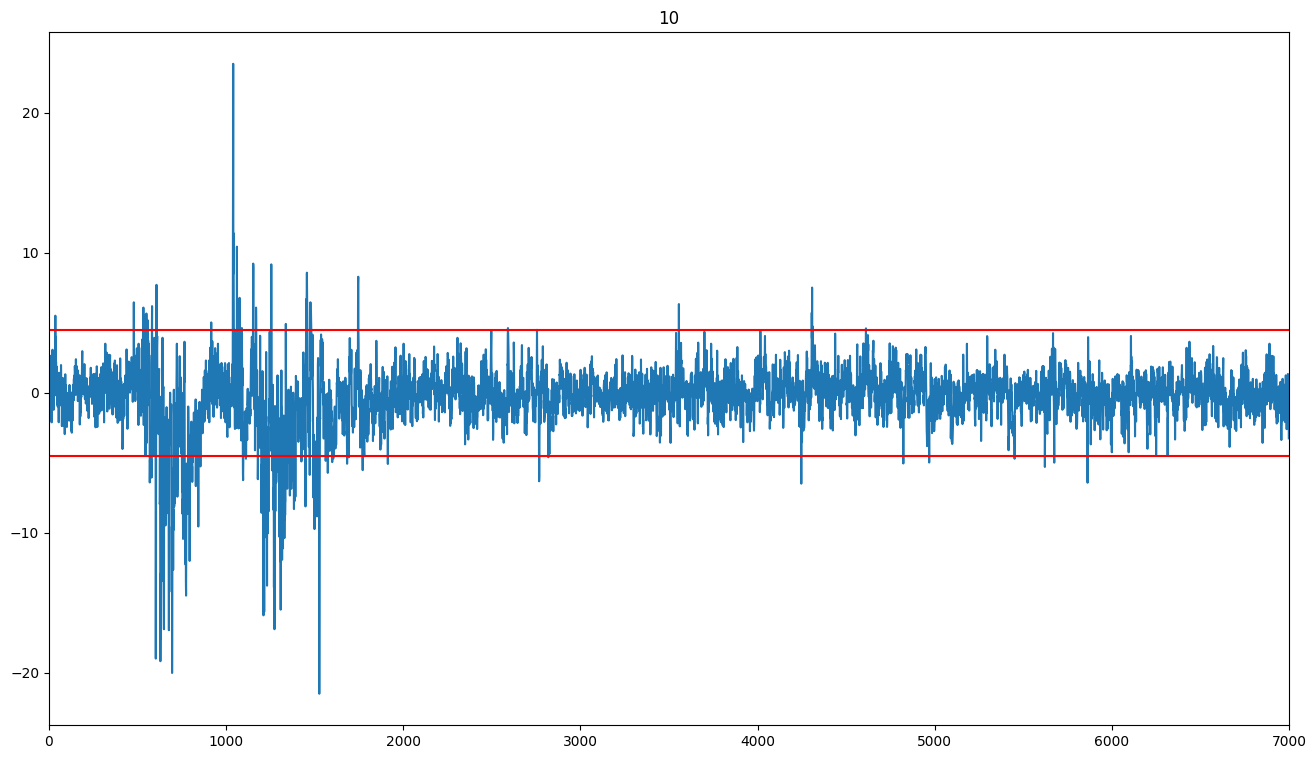

  0%|          | 18/1000000 [00:02<32:56:52,  8.43it/s]

samples: 13100


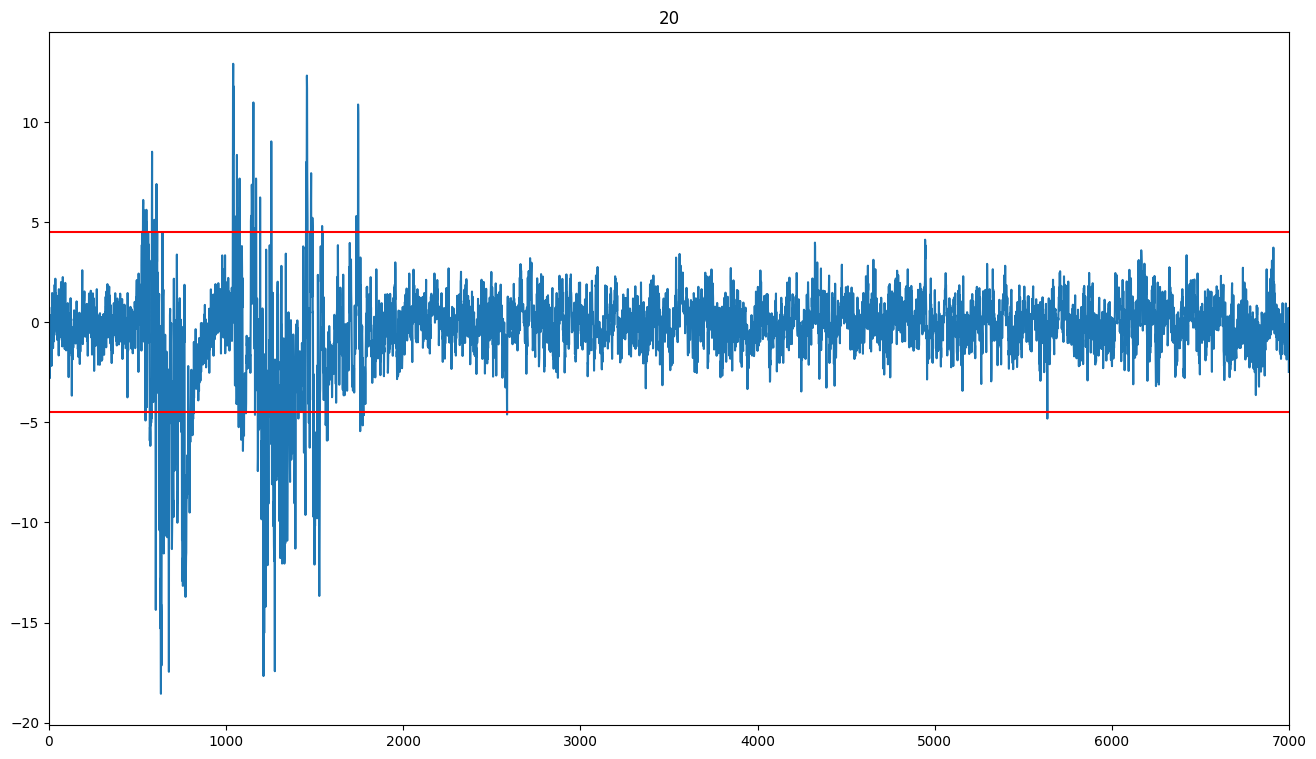

  0%|          | 28/1000000 [00:05<40:24:15,  6.87it/s]

samples: 13100


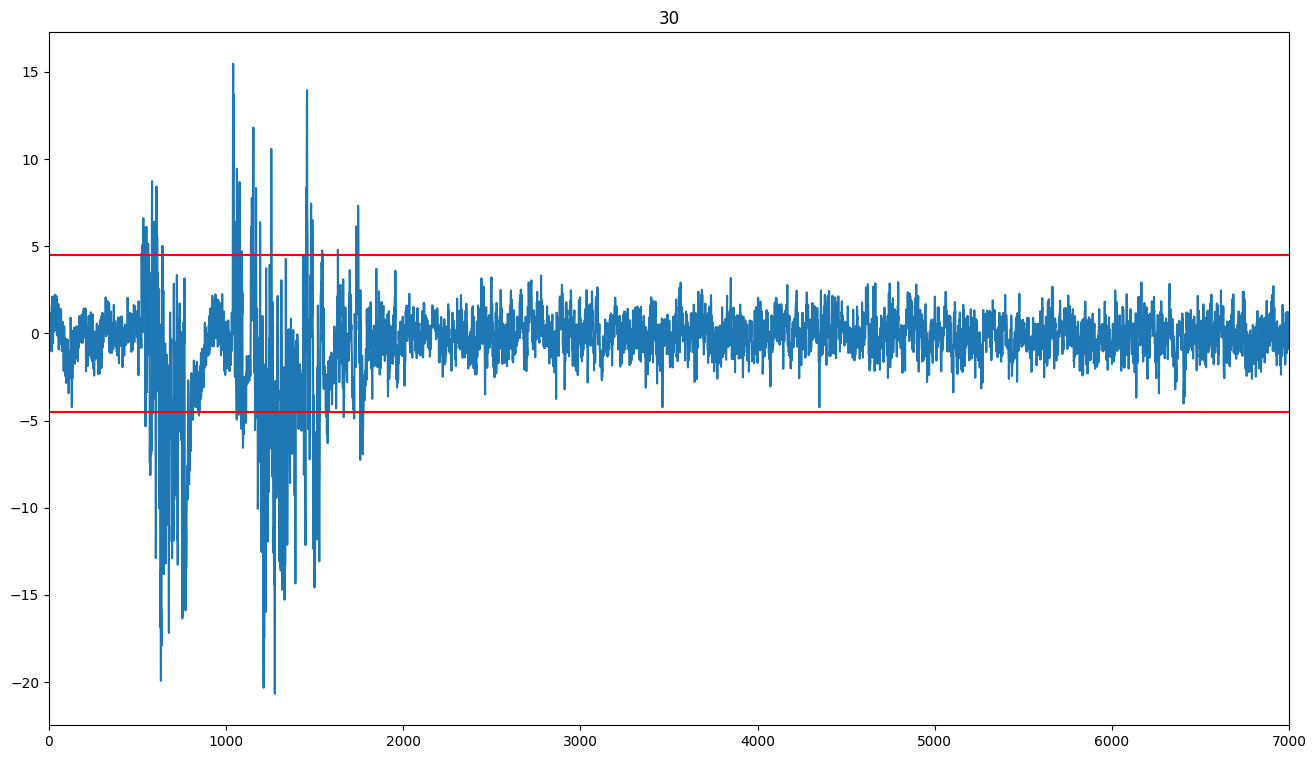

  0%|          | 48/1000000 [00:08<20:35:42, 13.49it/s] 

samples: 13100


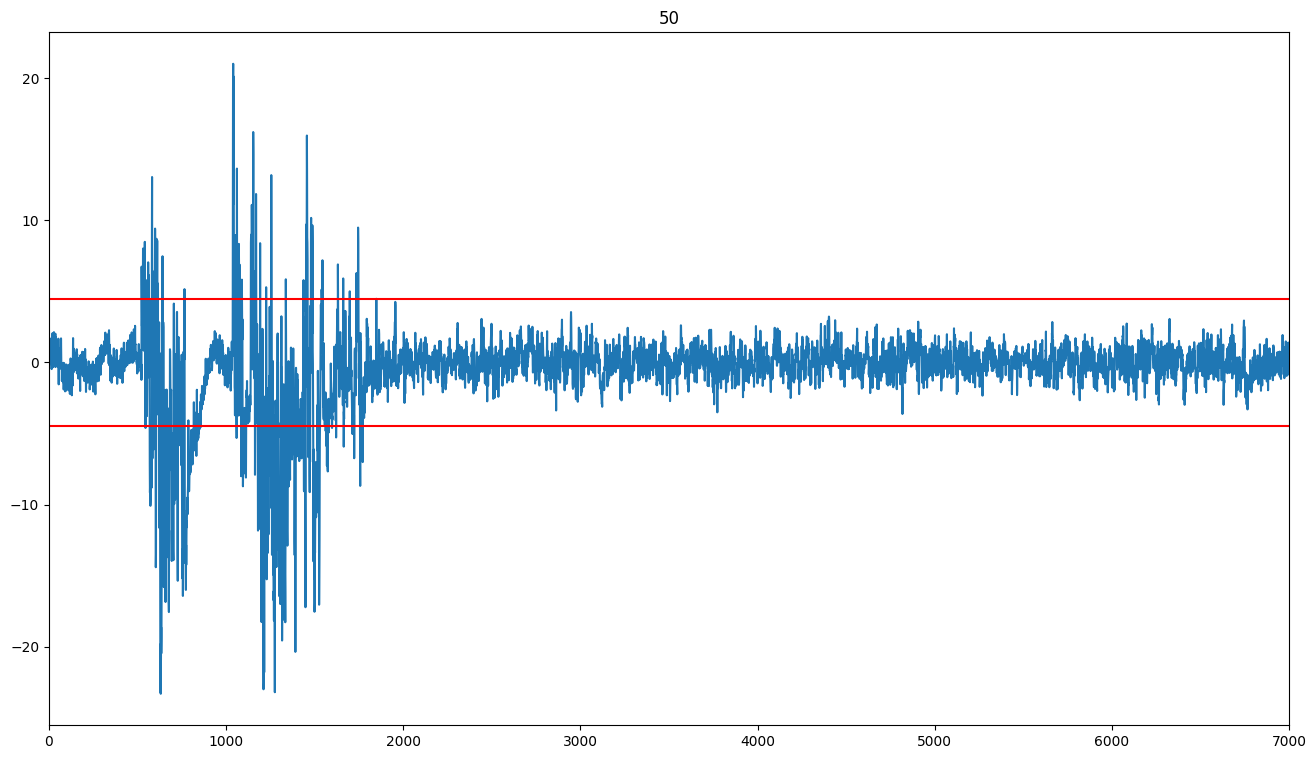

  0%|          | 98/1000000 [00:13<20:43:59, 13.40it/s]

samples: 13100


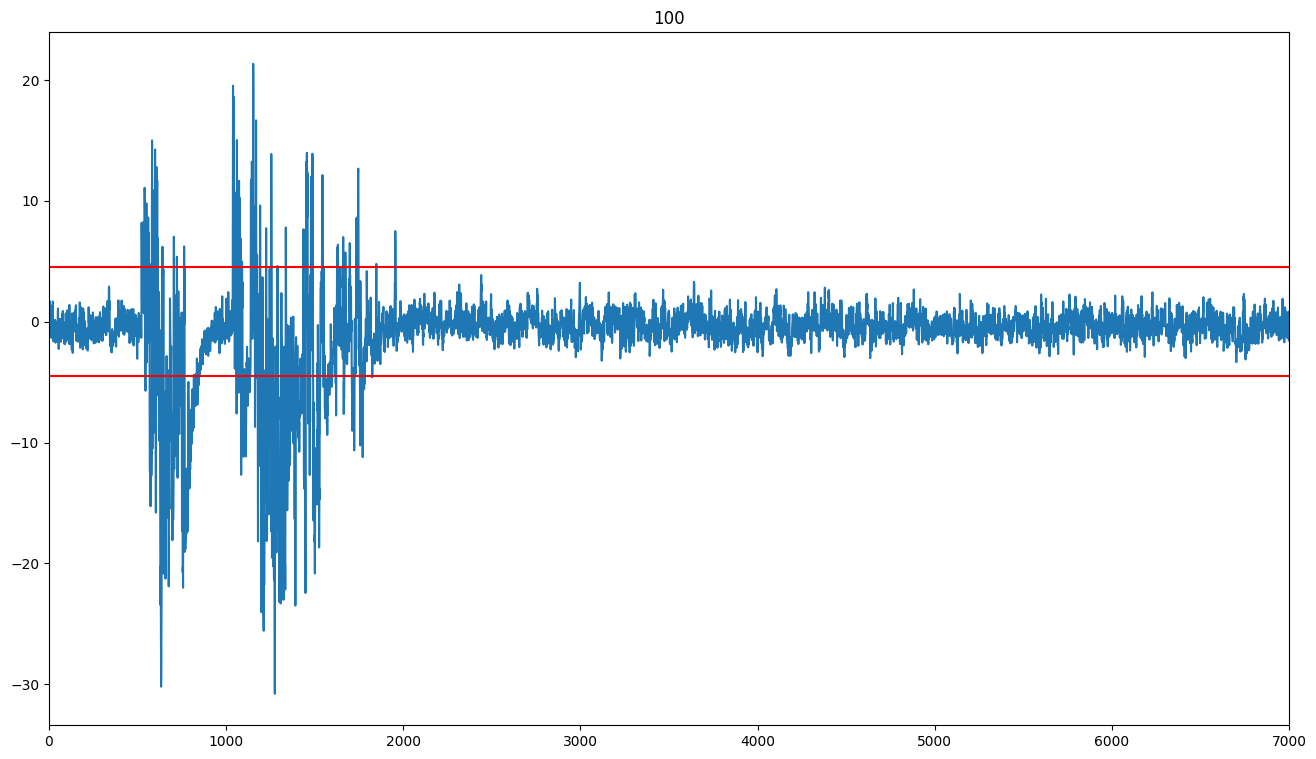

  0%|          | 898/1000000 [01:09<21:31:14, 12.90it/s]


KeyboardInterrupt: 

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import pathlib
from tqdm import tqdm
import time

# Measurement settings
traces = 1000000
samples_per_trace = 7000 #24400

# Variables for one-pass 1st-order t-test
n_fix = 0
n_rnd = 0
S1_fix = np.zeros((samples_per_trace,),dtype=np.double)
S1_rnd = np.zeros((samples_per_trace,),dtype=np.double)
S2_fix = np.zeros((samples_per_trace,),dtype=np.double)
S2_rnd = np.zeros((samples_per_trace,),dtype=np.double)

# Define input data
m = bytearray.fromhex('')
a = bytearray.fromhex('')
n = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
k = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
c = bytearray.fromhex('000102030405060708090a0b0c0d0e0f10111213')

#flags = M|A|N|RUN_ENC|OMIT_RESULT
flags = N|RUN_ENC|OMIT_RESULT
#flags = C|A|N|RUN_DEC|OMIT_RESULT

# Send key with data for less than 4 shares (data length <= 190 Bytes)
if NUM_SHARES_KEY < 4:
    flags |= K

# No adata for 3 shares and decryption (data length <= 190 Bytes)
if (NUM_SHARES_KEY >= 3) and (flags & C):
    a = bytearray.fromhex('')

target.flush()
scope.adc.samples = samples_per_trace
scope.clock.adc_src = 'clkgen_x1'  

progress = sorted(set([10,20,30,50,100, 1000, 2000, 5000, 10000, 20000, 30000, 40000, 50000, 100000, 200000, 300000, 400000 ,500000, traces]))
for i in tqdm(range(traces)):
    if NUM_SHARES_KEY >= 4:
        # Send key separately
        data = bytearray([K])
        data += generate_shares(k, NUM_SHARES_KEY)
        target.flush()
        target.simpleserial_write(CMD_ASCON, pad(data))
        time.sleep(0.02)
    # Setup data #
    data = bytearray([flags])
    coinflip = random.getrandbits(1)
    if coinflip:
        # Fix input
        if flags & RUN_ENC:
            data += bytearray([len(m)])
            data += generate_shares(m, NUM_SHARES_M)
        if flags & RUN_DEC:
            data += bytearray([len(c)])
            data += generate_shares(c[0:-16], NUM_SHARES_C)
            data += generate_shares(c[-16:], NUM_SHARES_C)
        data += bytearray([len(a)])
        data += generate_shares(a, NUM_SHARES_AD)
        data += generate_shares(n, NUM_SHARES_NPUB)
    else:
        # Random input
        if flags & RUN_ENC:
            data += bytearray([len(m)]) 
            data += generate_shares(bytearray((random.getrandbits(8) for x in range(len(m)))), NUM_SHARES_M)
        if flags & RUN_DEC:
            data += bytearray([len(c)])
            data += generate_shares(bytearray((random.getrandbits(8) for x in range(len(c)-16))), NUM_SHARES_C)
            data += generate_shares(bytearray((random.getrandbits(8) for x in range(16))), NUM_SHARES_C)
        data += bytearray([len(a)])
        data += generate_shares(bytearray((random.getrandbits(8) for x in range(len(a)))), NUM_SHARES_AD)
        data += generate_shares(bytearray((random.getrandbits(8) for x in range(len(n)))), NUM_SHARES_NPUB)
    if NUM_SHARES_KEY < 4:
        data += generate_shares(k, NUM_SHARES_KEY)
    # Measure trace #
    scope.arm()
    target.simpleserial_write(CMD_ASCON, pad(data))
    scope.capture()
    trace = scope.get_last_trace()   
    if i == 0:
        samples_per_trace = min(scope.adc.trig_count,samples_per_trace)
    # Process trace #
    if coinflip:
        n_fix += 1
        S1_fix += trace
        S2_fix += np.square(trace)
    else:
        n_rnd += 1
        S1_rnd += trace
        S2_rnd += np.square(trace)
    if i+1 in progress or (i+1)%1000000 == 0:
        print("samples: " + str(scope.adc.trig_count))
        # Generate t-test plot
        mu_fix = S1_fix/n_fix
        mu_rnd = S1_rnd/n_rnd
        var_fix = S2_fix/n_fix - np.square(mu_fix)
        var_rnd = S2_rnd/n_rnd - np.square(mu_rnd)
        tscore = np.divide((mu_fix - mu_rnd),np.sqrt(var_fix/n_fix + var_rnd/n_rnd))
        tscore = tscore[:samples_per_trace]
        plt.figure(figsize=(16,9))
        plt.plot(tscore)
        plt.plot([0,len(tscore)-1],[4.5,4.5],'r-')
        plt.plot([0,len(tscore)-1],[-4.5,-4.5],'r-')
        plt.title(str(n_fix+n_rnd))
        plt.xlim((0,len(tscore)))
        #plt.ylim((-10,10))
        pathlib.Path("ttest").mkdir(parents=True, exist_ok=True)
        #plt.savefig("ttest/" + PLATFORM + "_{}.png".format(n_fix+n_rnd))
        plt.savefig("ttest/" + PLATFORM + "_{}.pdf".format(n_fix+n_rnd), format="pdf", bbox_inches='tight')
        plt.show()
        #plt.rcParams.update({
        #"pgf.texsystem": "pdflatex",
        #"   font.family": "serif",  # or sans-serif
        #"text.usetex": True,
        #"pgf.rcfonts": False,
        #})
         #plt.savefig("t_test_results.pgf")
#plt.show()        

In [144]:
print("samples: " + str(scope.adc.trig_count))
print("cycles:  " + str(scope.adc.trig_count//4))

samples: 686052
cycles:  171513


  0%|          | 49/1000000 [00:05<31:47:06,  8.74it/s]

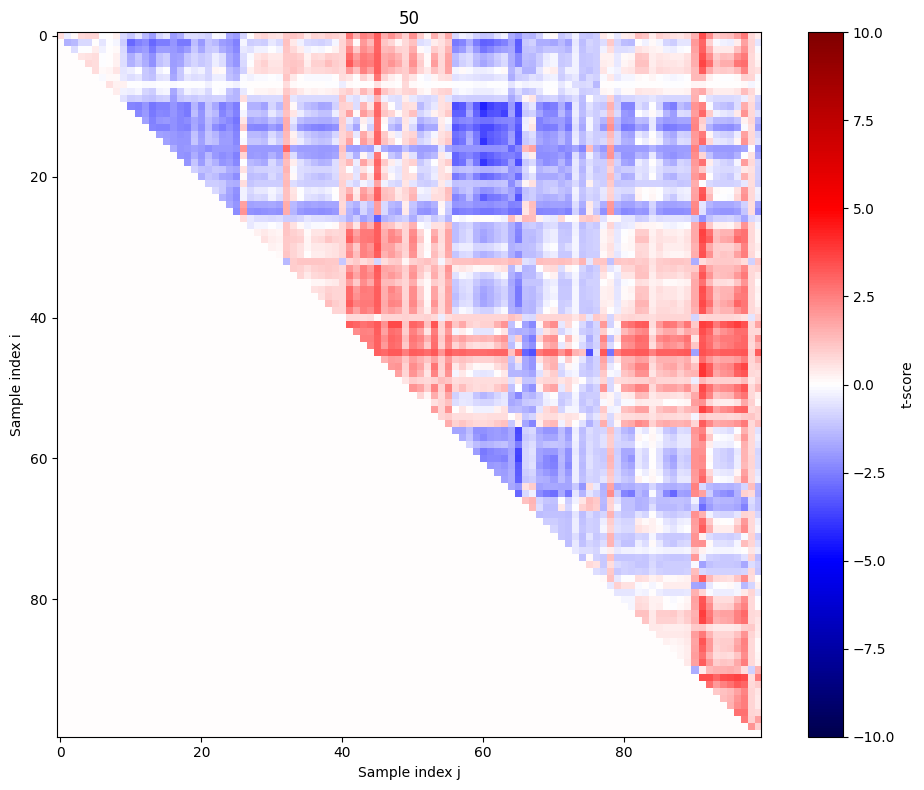

  0%|          | 999/1000000 [01:45<27:13:27, 10.19it/s]

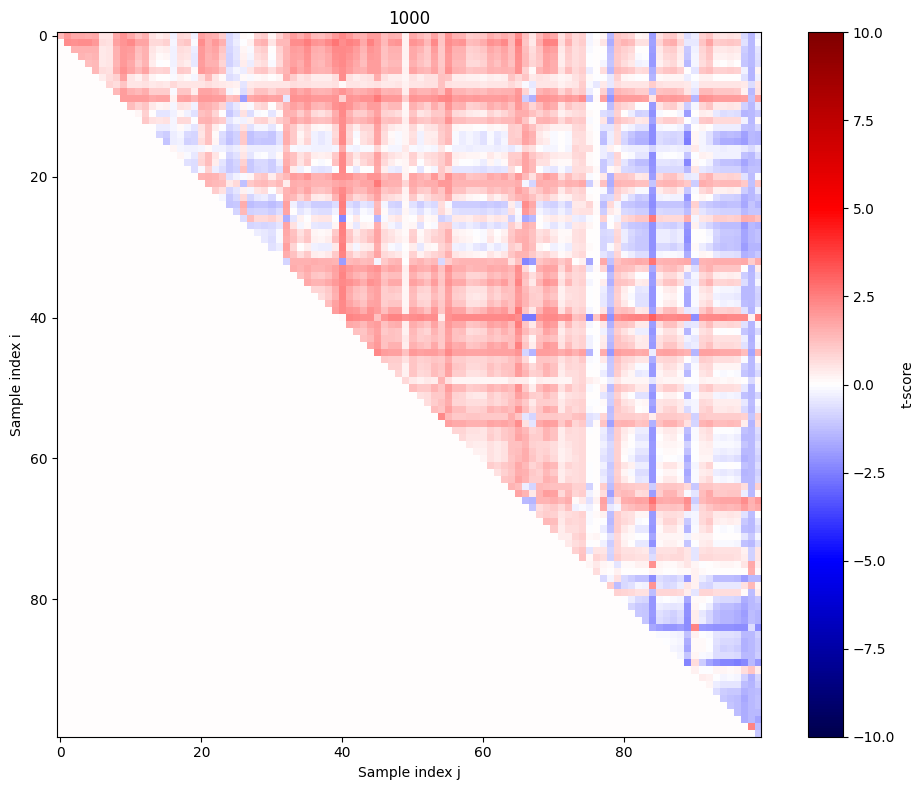

  0%|          | 1998/1000000 [03:26<33:08:14,  8.37it/s] 

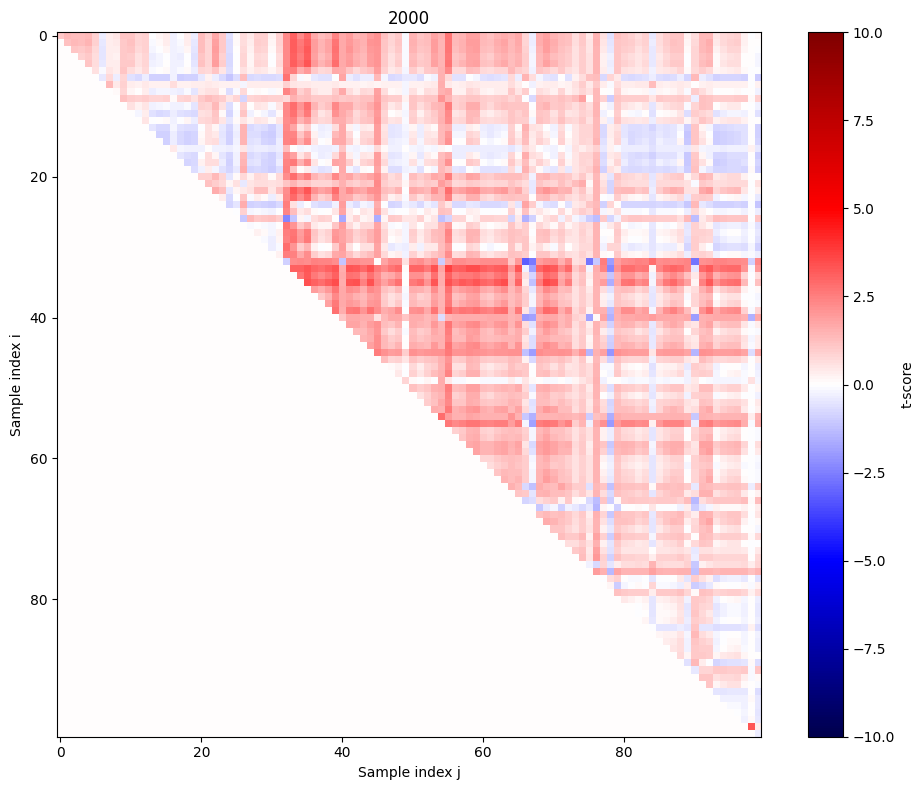

  0%|          | 4999/1000000 [08:32<25:06:04, 11.01it/s] 

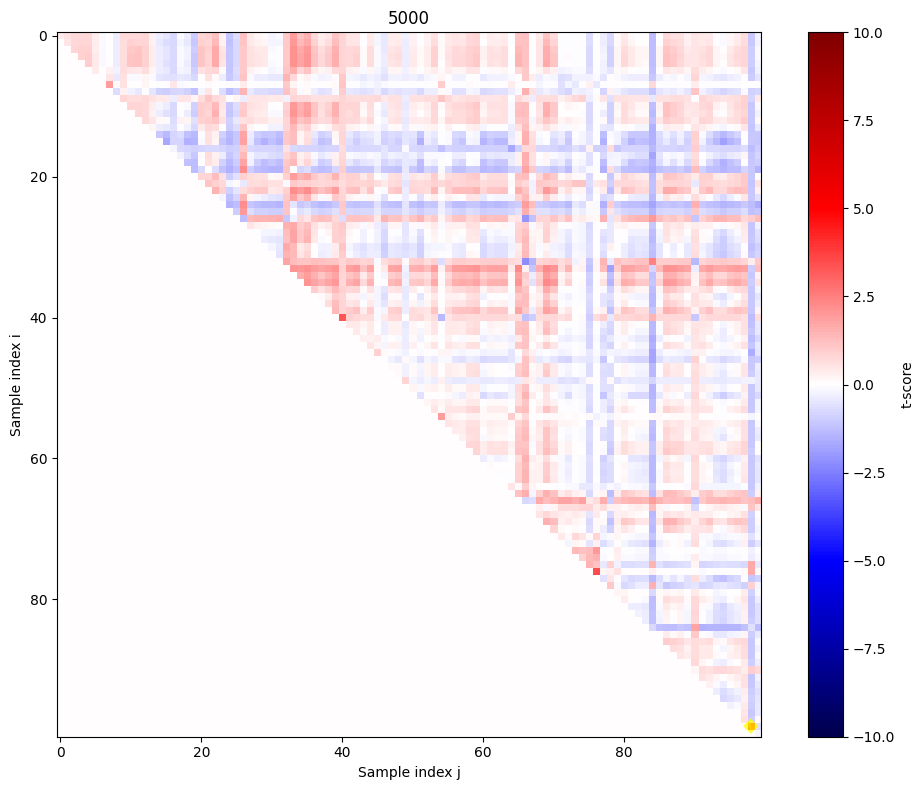

  1%|          | 9998/1000000 [17:03<30:12:55,  9.10it/s] 

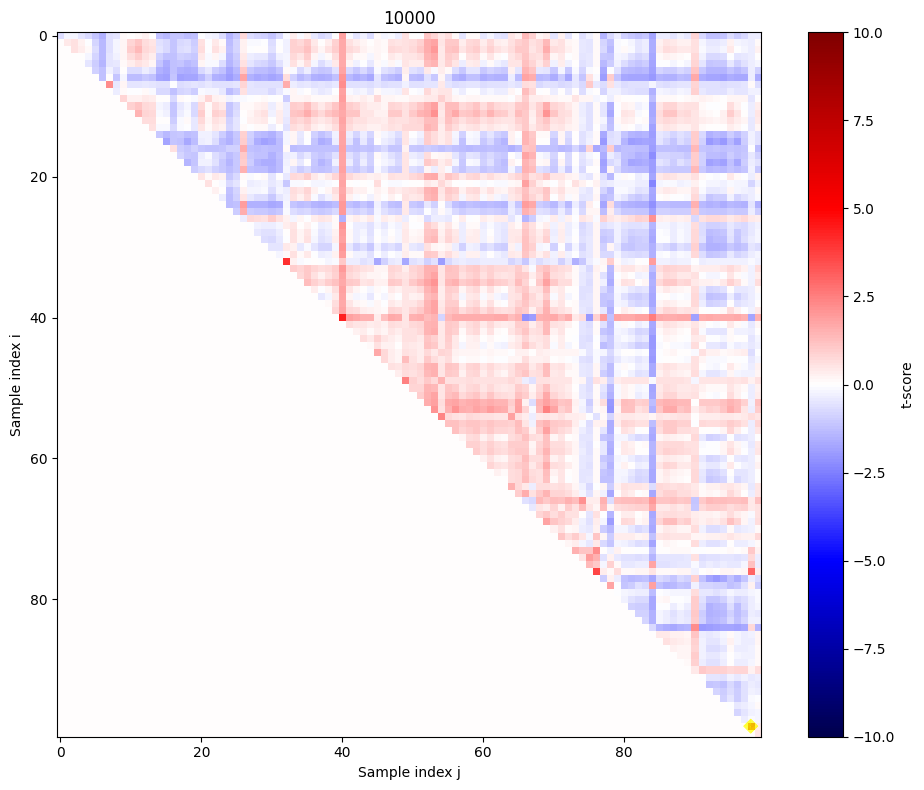

  2%|▏         | 19999/1000000 [33:55<26:45:13, 10.18it/s] 

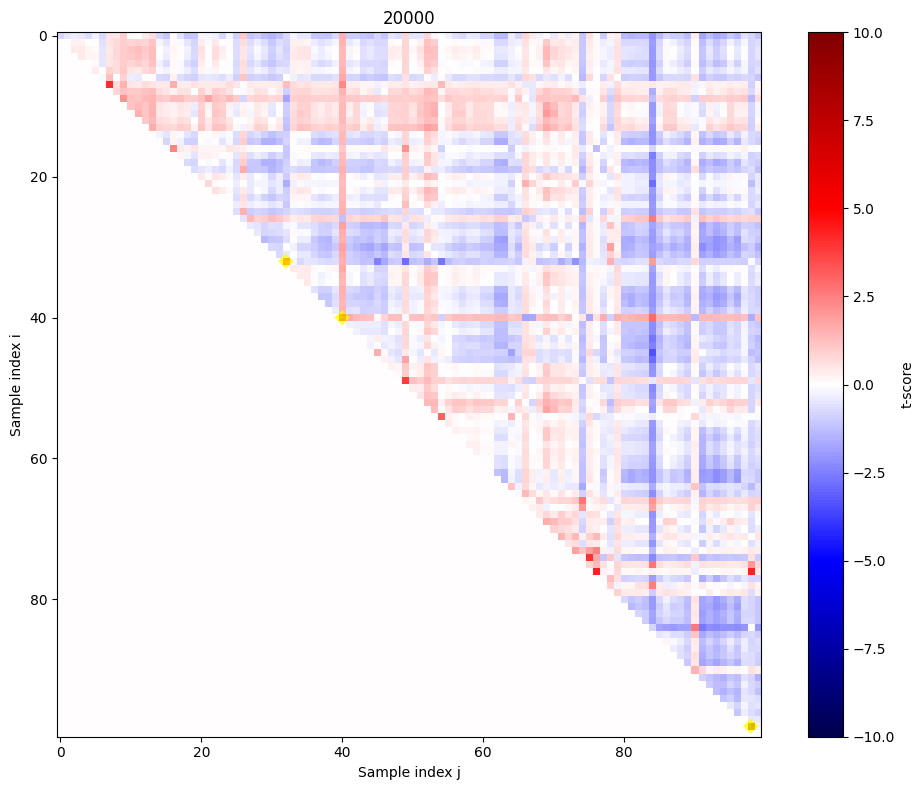

  3%|▎         | 29999/1000000 [50:32<26:22:21, 10.22it/s] 

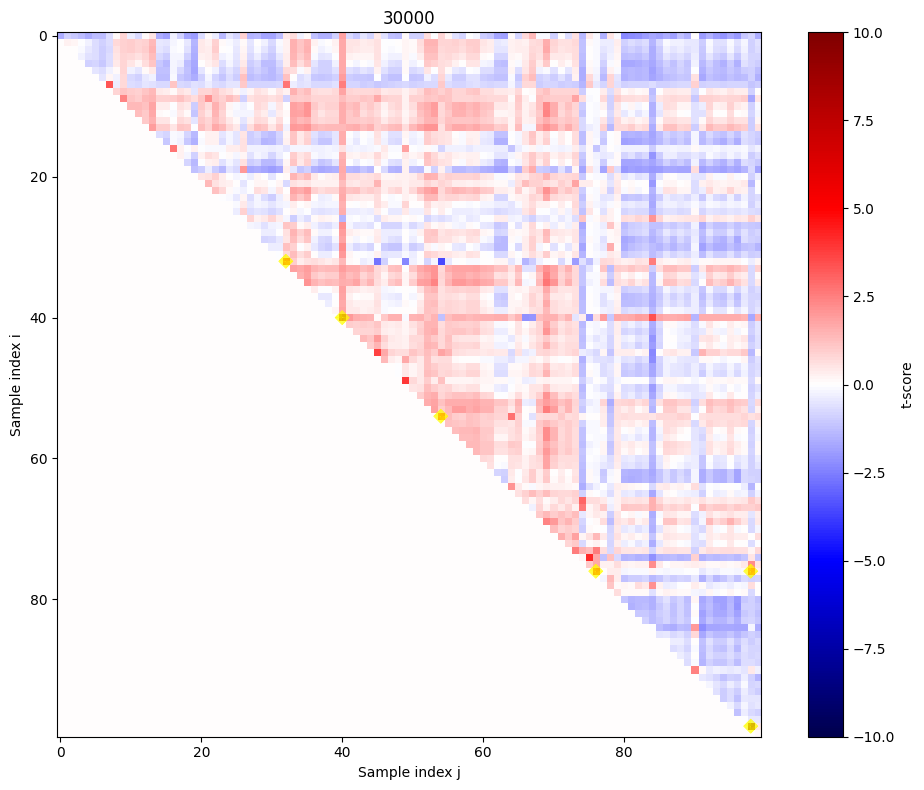

  4%|▍         | 39998/1000000 [1:07:14<26:00:23, 10.25it/s]

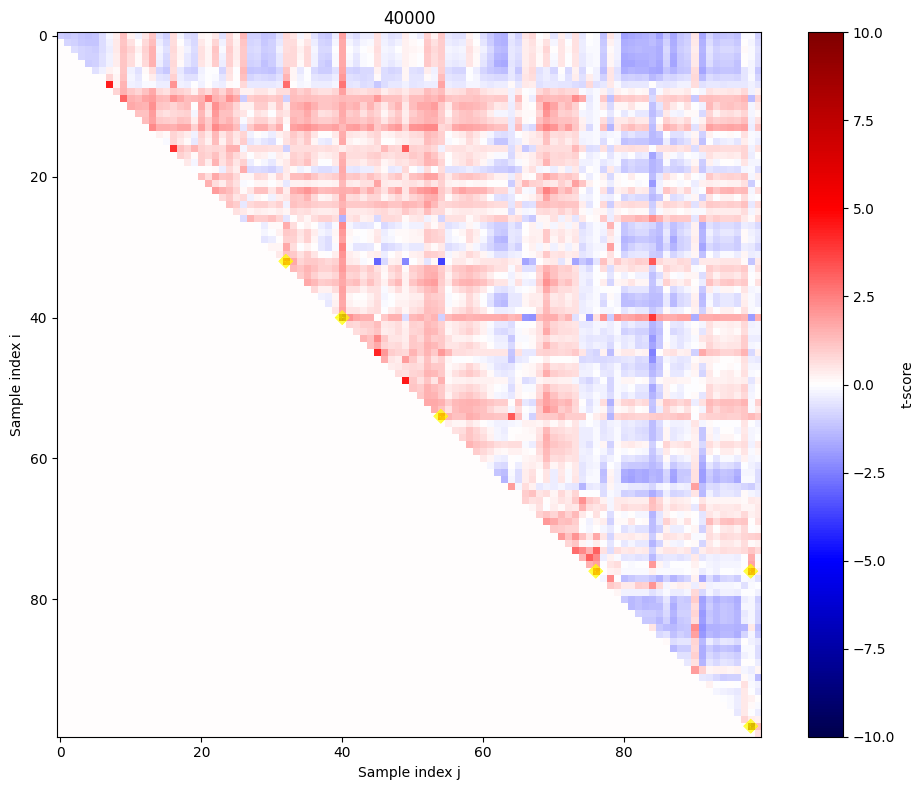

  4%|▍         | 40587/1000000 [1:08:16<27:56:36,  9.54it/s] 

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pathlib
from tqdm import tqdm
import time

# Measurement settings
traces = 1000000
samples_per_trace = 24400

# Variables for one-pass 1st-order t-test
n_fix = 0
n_rnd = 0
ind1 = 1200#1050#1150
ind2 = 1300
region_length = ind2 - ind1

S1_fix2 = np.zeros((region_length, region_length), dtype=np.double)
S1_rnd2 = np.zeros((region_length, region_length), dtype=np.double)
S2_fix2 = np.zeros((region_length, region_length), dtype=np.double)
S2_rnd2 = np.zeros((region_length, region_length), dtype=np.double)

# Define input data
m = bytearray.fromhex('')
a = bytearray.fromhex('')
n = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
k = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
c = bytearray.fromhex('000102030405060708090a0b0c0d0e0f10111213')

#flags = M|A|N|RUN_ENC|OMIT_RESULT
flags = N|RUN_ENC|OMIT_RESULT
#flags = C|A|N|RUN_DEC|OMIT_RESULT

# Send key with data for less than 4 shares (data length <= 190 Bytes)
if NUM_SHARES_KEY < 4:
    flags |= K

# No adata for 3 shares and decryption (data length <= 190 Bytes)
if (NUM_SHARES_KEY >= 3) and (flags & C):
    a = bytearray.fromhex('')

target.flush()
scope.adc.samples = samples_per_trace
scope.clock.adc_src = 'clkgen_x1'  

progress = sorted(set([50,1000, 2000, 5000, 10000, 20000, 30000, 40000, 50000, 100000, 200000, 300000, 400000 ,500000, traces]))
for i in tqdm(range(traces)):
    if NUM_SHARES_KEY >= 4:
        # Send key separately
        data = bytearray([K])
        data += generate_shares(k, NUM_SHARES_KEY)
        target.flush()
        target.simpleserial_write(CMD_ASCON, pad(data))
        time.sleep(0.02)
    # Setup data #
    data = bytearray([flags])
    coinflip = random.getrandbits(1)
    if coinflip:
        # Fix input
        if flags & RUN_ENC:
            data += bytearray([len(m)])
            data += generate_shares(m, NUM_SHARES_M)
        if flags & RUN_DEC:
            data += bytearray([len(c)])
            data += generate_shares(c[0:-16], NUM_SHARES_C)
            data += generate_shares(c[-16:], NUM_SHARES_C)
        data += bytearray([len(a)])
        data += generate_shares(a, NUM_SHARES_AD)
        data += generate_shares(n, NUM_SHARES_NPUB)
    else:
        # Random input
        if flags & RUN_ENC:
            data += bytearray([len(m)]) 
            data += generate_shares(bytearray((random.getrandbits(8) for x in range(len(m)))), NUM_SHARES_M)
        if flags & RUN_DEC:
            data += bytearray([len(c)])
            data += generate_shares(bytearray((random.getrandbits(8) for x in range(len(c)-16))), NUM_SHARES_C)
            data += generate_shares(bytearray((random.getrandbits(8) for x in range(16))), NUM_SHARES_C)
        data += bytearray([len(a)])
        data += generate_shares(bytearray((random.getrandbits(8) for x in range(len(a)))), NUM_SHARES_AD)
        data += generate_shares(bytearray((random.getrandbits(8) for x in range(len(n)))), NUM_SHARES_NPUB)
    if NUM_SHARES_KEY < 4:
        data += generate_shares(k, NUM_SHARES_KEY)
    # Measure trace #
    scope.arm()
    target.simpleserial_write(CMD_ASCON, pad(data))
    scope.capture()
    trace = scope.get_last_trace()      
    region = trace[ind1:ind2]
    if coinflip:
        n_fix +=1            
    else:
        n_rnd+=1

    for i_ in range(region_length):
     for j in range(i_, region_length):  # Only upper triangle (symmetric)
        z = region[i_] * region[j]
        if coinflip:           
            S1_fix2[i_][j] += z
            S2_fix2[i_][j] += z**2
        else:
            S1_rnd2[i_][j] += z
            S2_rnd2[i_][j] += z**2

    if i+1 in progress or (i+1)%1000000 == 0:        
        mu_fix2 = S1_fix2 / n_fix
        mu_rnd2 = S1_rnd2 / n_rnd
        var_fix2 = S2_fix2 / n_fix - mu_fix2**2
        var_rnd2 = S2_rnd2 / n_rnd - mu_rnd2**2
        denom = np.sqrt(var_fix2 / n_fix + var_rnd2 / n_rnd)
        with np.errstate(divide='ignore', invalid='ignore'):
            T = (mu_fix2 - mu_rnd2) / denom
            T[np.isnan(T)] = 0  # Clean up NaNs
        #for i_t1 in range(region_length):
        #    for j_t2 in range(i_t1):
        #        T[i_t1][j_t2] = T[j_t2][i_t1]

        # Plot 2D heatmap
        plt.figure(figsize=(10, 8))
        plt.imshow(T, cmap="seismic", vmin=-10, vmax=10, interpolation='none')
        plt.colorbar(label='t-score')
        plt.title(f"{n_fix + n_rnd}")
        plt.xlabel("Sample index j")
        plt.ylabel("Sample index i")

        # Optional: Overlay threshold contour
        plt.contour((np.abs(T) > 4.5).astype(int), colors='yellow', linewidths=0.5)

        plt.tight_layout()
        plt.savefig(f"ttest/{PLATFORM}_second_order_heatmap_{ind1}_{ind2}_{n_fix+n_rnd}.pdf", bbox_inches='tight')  
        plt.show()

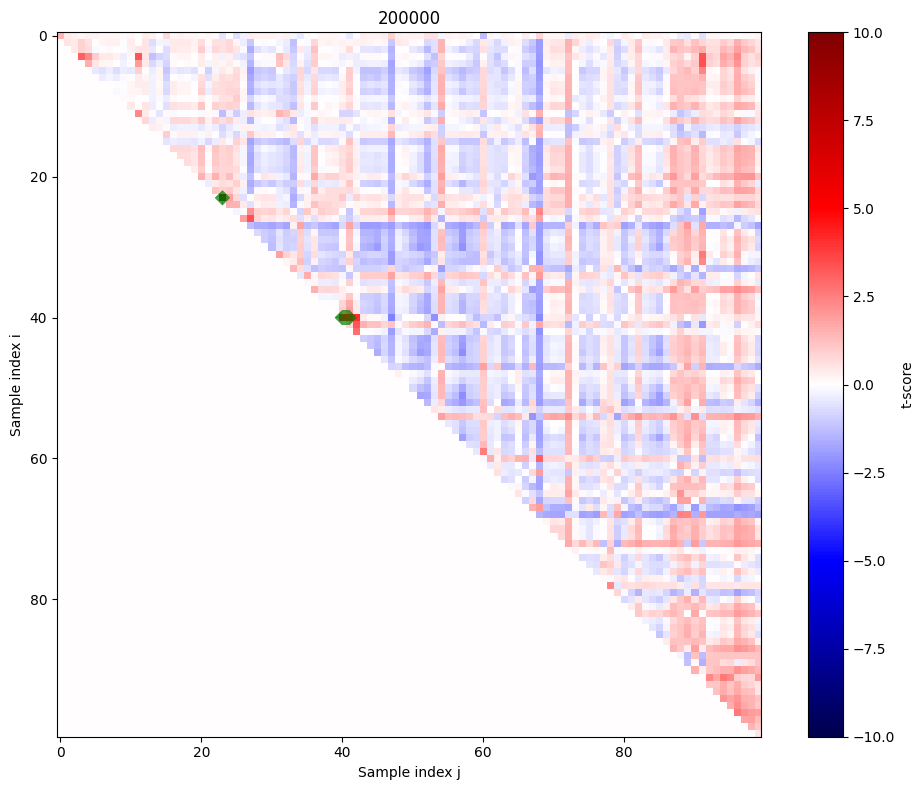

In [16]:
        mu_fix2 = S1_fix2 / n_fix
        mu_rnd2 = S1_rnd2 / n_rnd
        var_fix2 = S2_fix2 / n_fix - mu_fix2**2
        var_rnd2 = S2_rnd2 / n_rnd - mu_rnd2**2
        denom = np.sqrt(var_fix2 / n_fix + var_rnd2 / n_rnd)
        with np.errstate(divide='ignore', invalid='ignore'):
            T = (mu_fix2 - mu_rnd2) / denom
            T[np.isnan(T)] = 0  # Clean up NaNs
        #for i_t1 in range(region_length):
        #    for j_t2 in range(i_t1):
        #        T[i_t1][j_t2] = T[j_t2][i_t1]

        # Plot 2D heatmap
        plt.figure(figsize=(10, 8))
        plt.imshow(T, cmap="seismic", vmin=-10, vmax=10, interpolation='none')
        plt.colorbar(label='t-score')
        plt.title(f"{200000}")
        plt.xlabel("Sample index j")
        plt.ylabel("Sample index i")

        # Optional: Overlay threshold contour
        plt.contour((np.abs(T) > 4.5).astype(int), colors='green', linewidths=0.5)

        plt.tight_layout()
        plt.savefig(f"ttest/{PLATFORM}_second_order_heatmap__{ind1}_{ind2}_{n_fix+n_rnd}.pdf", bbox_inches='tight')  
        plt.show()

## Disconnect from Board

In [25]:
scope.dis()
target.dis()

(ChipWhisperer Scope ERROR|File naeusbchip.py:112) Scope already disconnected!
